In [12]:
import matplotlib.pyplot as plt
from   matplotlib.colors import LogNorm
import numpy as np
from   scipy.stats import norm
from   scipy.special import logsumexp

In [2]:

class GaussianUnknownMean:
    
    def __init__(self, mean0, var0, varx):
        """Initialize model.
        
        meanx is unknown; varx is known
        p(meanx) = N(mean0, var0)
        p(x) = N(meanx, varx)
        """
        self.mean0 = mean0
        self.var0  = var0
        self.varx  = varx
        self.mean_params = np.array([mean0])
        self.prec_params = np.array([1/var0])
    
    def log_pred_prob(self, t, x):
        post_means = self.mean_params[:t]
        post_stds  = np.sqrt(self.var_params[:t])
        return norm(post_means, post_stds).logpdf(x)
    
    def update_params(self, t, x):
        """Upon observing a new datum x at time t, update all run length 
        hypotheses.
        """
    
        new_prec_params  = self.prec_params + (1/self.varx)
        self.prec_params = np.append([1/self.var0], new_prec_params)
      
        new_mean_params  = (self.mean_params * self.prec_params[:-1] + \
                            (x / self.varx)) / new_prec_params
        self.mean_params = np.append([self.mean0], new_mean_params)

    @property
    def var_params(self):
        """Helper function for computing the posterior variance.
        """
        return 1./self.prec_params + self.varx


<>:17: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\p'
C:\Users\a2839\AppData\Local\Temp\ipykernel_22624\444428671.py:17: SyntaxWarning: invalid escape sequence '\p'
  """Compute predictive probabilities \pi, i.e. the posterior predictive


0       0.213170
1       0.207589
2       0.202009
3       0.200893
4       0.206473
          ...   
1862    0.469286
1863    0.484643
1864    0.487500
1865    0.485536
1866    0.483214
Name: Close, Length: 1867, dtype: float64

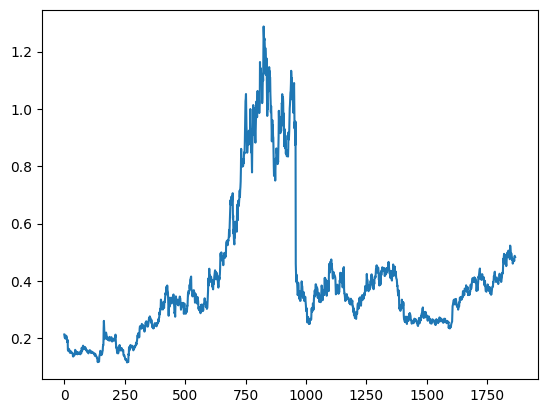

In [14]:
df = pd.read_csv(r"C:\Users\a2839\OneDrive\文档\CATAM\1.2 ODE\Applie_stock.csv")
data = df['Close']
plt.plot(data)
data

In [7]:
def bocd(data, model, hazard):

    # 1. Initialize lower triangular matrix representing the posterior as
    #    function of time. Model parameters are initialized in the model class.
    #    
    #    When we exponentiate R at the end, exp(-inf) --> 0, which is nice for
    #    visualization.
    #

    log_R       = -np.inf * np.ones((T+1, T+1))
    log_R[0, 0] = 0              # log 0 == 1
    pmean       = np.empty(T)    # Model's predictive mean.
    pvar        = np.empty(T)    # Model's predictive variance. 
    log_message = np.array([0])  # log 0 == 1
    log_H       = np.log(hazard)
    log_1mH     = np.log(1 - hazard)

    for t in range(1, T+1):
        # 2. Observe new datum.
        x = data[t-1]

        # Make model predictions.
        pmean[t-1] = np.sum(np.exp(log_R[t-1, :t]) * model.mean_params[:t])
        pvar[t-1]  = np.sum(np.exp(log_R[t-1, :t]) * model.var_params[:t])
        
        # 3. Evaluate predictive probabilities.
        log_pis = model.log_pred_prob(t, x)

        # 4. Calculate growth probabilities.
        log_growth_probs = log_pis + log_message + log_1mH

        # 5. Calculate changepoint probabilities.
        log_cp_prob = logsumexp(log_pis + log_message + log_H)

        # 6. Calculate evidence
        new_log_joint = np.append(log_cp_prob, log_growth_probs)

        # 7. Determine run length distribution.
        log_R[t, :t+1]  = new_log_joint
        log_R[t, :t+1] -= logsumexp(new_log_joint)

        # 8. Update sufficient statistics.
        model.update_params(t, x)

        # Pass message.
        log_message = new_log_joint

    R = np.exp(log_R)
    return R, pmean, pvar



In [17]:
def plot_posterior(T, data, cps, R, pmean, pvar):
    fig, axes = plt.subplots(2, 1, figsize=(20,10))

    ax1, ax2 = axes

    ax1.scatter(range(0, T), data)
    ax1.plot(range(0, T), data)
    ax1.set_xlim([0, T])
    ax1.margins(0)
    
    # Plot predictions.
    ax1.plot(range(0, T), pmean, c='k')
    _2std = 2 * np.sqrt(pvar)
    ax1.plot(range(0, T), pmean - _2std, c='k', ls='--')
    ax1.plot(range(0, T), pmean + _2std, c='k', ls='--')

    ax2.imshow(np.rot90(R), aspect='auto', cmap='gray_r', 
               norm=LogNorm(vmin=0.0001, vmax=1))
    ax2.set_xlim([0, T])
    ax2.margins(0)

    plt.tight_layout()
    plt.show()

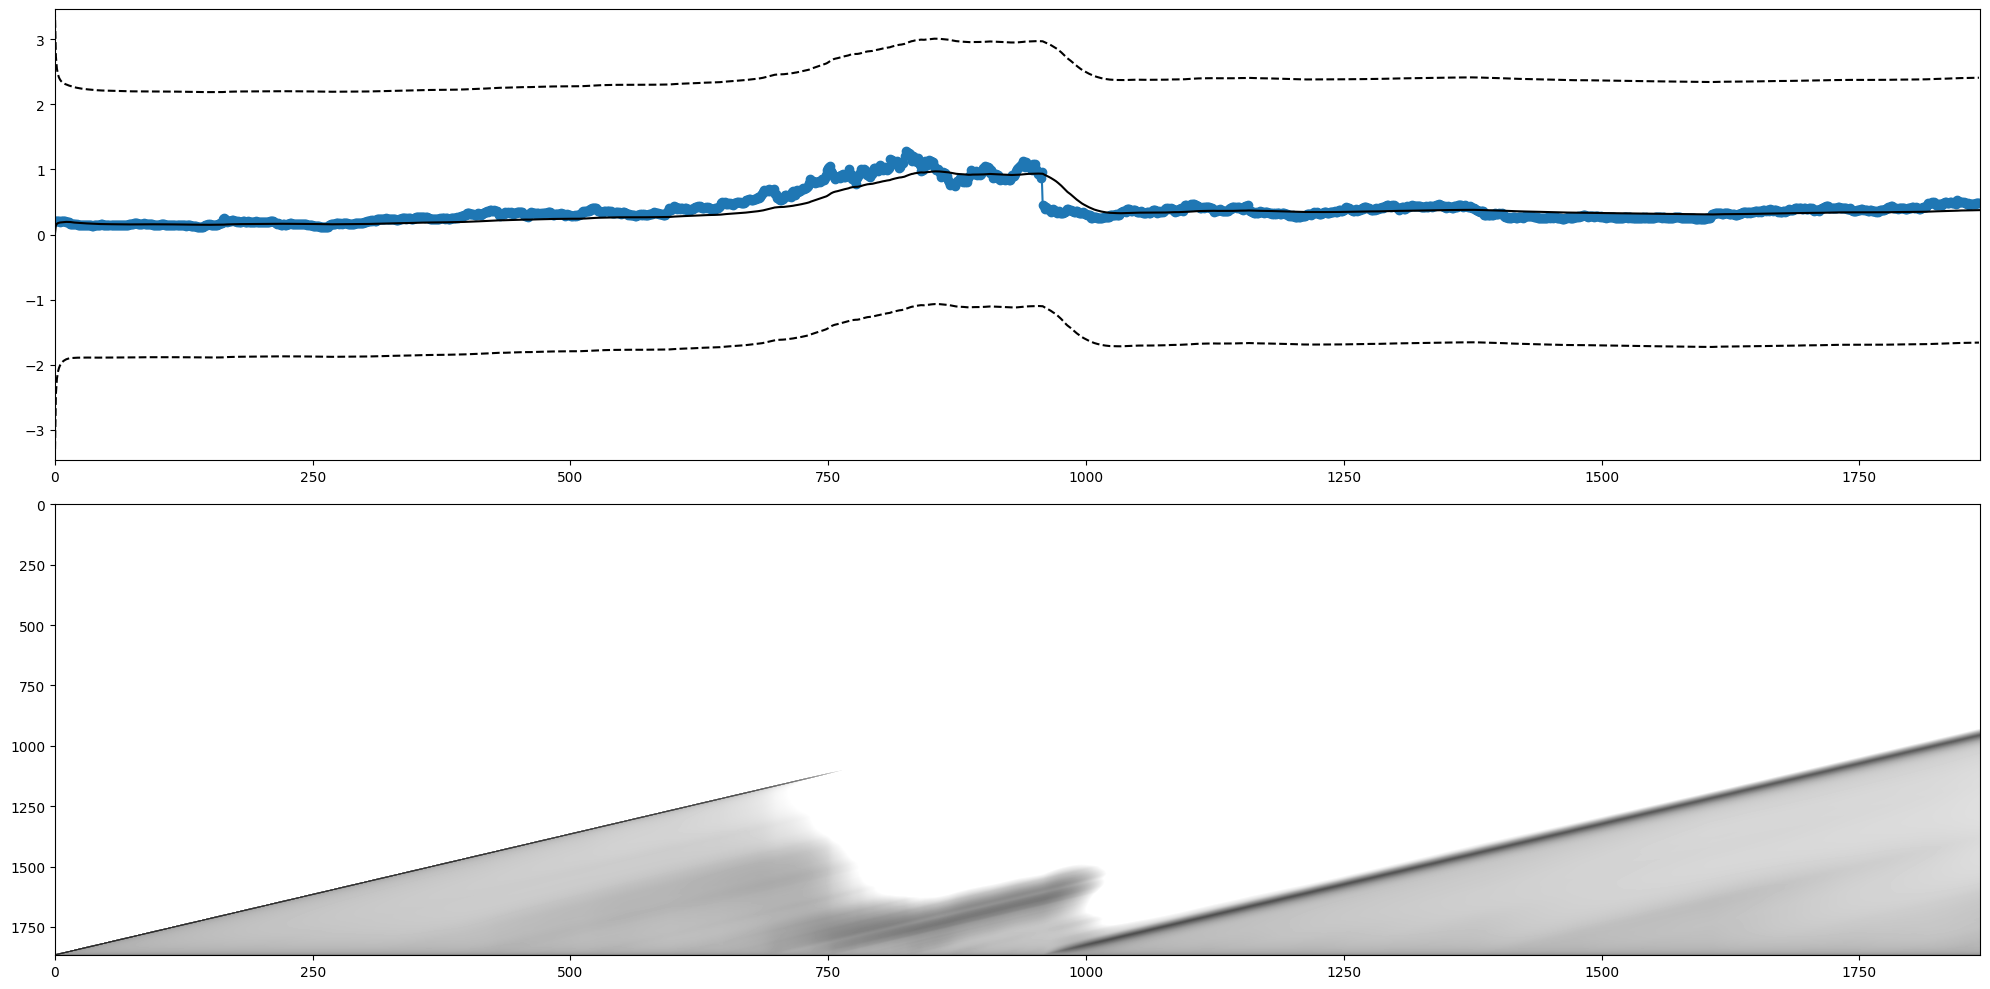

In [18]:
T      = 1867   # Number of observations.
hazard = 1/100  # Constant prior on changepoint probability.
mean0  = 0      # The prior mean on the mean parameter.
var0   = 2      # The prior variance for mean parameter.
varx   = 1      # The known variance of the data.

data, cps      = data,np.array([i for i in range(1867)])
model          = GaussianUnknownMean(mean0, var0, varx)
R, pmean, pvar = bocd(data, model, hazard)

plot_posterior(T, data, cps, R, pmean, pvar)